# A comparison between different fitting models using the Beysian Information Criterion
Explicit comparison between fitting directly to the raw data vs to the binned data for different order polynomials.

In [1]:
import igraph
import numpy as np
import matplotlib.pyplot as plt
import graph_functions
import scipy.stats as stats

from scipy.odr import ODR, Model, Data, RealData

In [2]:
%matplotlib inline
# %matplotlib qt5

# plt.style.use('ggplot')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"]})

In [3]:
# b[0] * x ** 0 + b[1] * x ** 1 + b[2] * x ** 2 + ...
def polynomial_series (beta, x):
    return sum([b * x ** i for i,b in enumerate(beta)])

In [4]:
N = 3_000
m = 2
x_line = np.linspace(0,5,1000)

g = igraph.Graph.Barabasi(N,m)

In [5]:
d_np = np.array(g.degree())
c_np = np.array(g.closeness())

In [6]:
d_log = np.log(d_np)
c_inv = 1 / c_np

x,y,sdx,sdy = graph_functions.closeness_and_degree_to_x_y_bins(c_np, d_np)

In [7]:
bin_odrs = []
raw_odrs = []

model = Model(polynomial_series)
binned_data = RealData(x,y,sdx,sdy)
raw_data = RealData(d_log, c_inv)

for i in range(5):
    # Binned data
    odr = ODR(binned_data, model, [0] * (i + 1))
    odr.set_job(fit_type=0)
    output = odr.run()
    bin_odrs.append(output)

    # Raw data (Set to 0 for werid fits)
    odr = ODR(raw_data, model, [-1] * (i + 1))
    odr.set_job(fit_type=2)
    output = odr.run()
    raw_odrs.append(output)

For the raw data it makes sense that the better fit is given with a *fit_type*=2 since otherwise the best fit is up between the two degree lines

Text(0, 0.5, 'Closeness$^{-1}$')

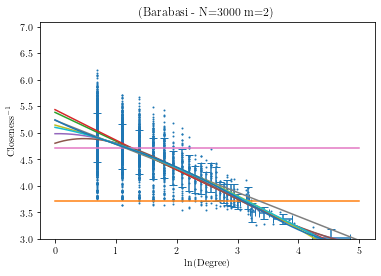

In [8]:
plt.scatter(d_log, c_inv,s=1, label='Raw data')
plt.errorbar(x,y,sdy,sdx,capsize=4,linestyle='none', label='Binned data')

for o in bin_odrs:
    plt.plot(x_line,polynomial_series(o.beta,x_line))

for o in raw_odrs:
    plt.plot(x_line,polynomial_series(o.beta,x_line))

plt.ylim((3,7.1))
plt.title(f'(Barabasi - N={N} m={m})')
plt.xlabel('ln(Degree)')
plt.ylabel('Closeness$^{-1}$') 

In [25]:
def bic_val(f, beta, x,y,sdy=[]):
    k = len(beta)
    if len(sdy) != 0:
        log_L_max = sum([np.log(gaussian(y_i, f(beta, x_i), sy)) for x_i, y_i, sy in zip(x,y,sdy)])
    else:
        residuals = list(map(lambda point: (point[1] - f(beta, point[0])),zip(d_log, c_inv)))
        mean, gaussian_std = stats.norm.fit(residuals)
        # log_L_max = sum([np.log(gaussian(y_i, f(beta, x_i), gaussian_std)) for x_i, y_i in zip(x,y)])
        # f, beta, gaussian_std, x, y
        log_L_max = graph_functions.log_likelihood_gauss_regression(f, beta, gaussian_std, x, y)
    return k * np.log(len(x)) - 2 * log_L_max, log_L_max, len(beta)

In [26]:
def log_likelihood_gauss_regression(f, beta, gaussian_std, x, y):
    return sum([np.log(gaussian(y_i, f(beta, x_i), gaussian_std)) for x_i, y_i in zip(x,y)])

In [27]:
def gaussian(x, mean, std):
    return 1.0/(std * np.sqrt(2*np.pi)) * np.exp( -1/2 * ( ( (x - mean)/std ) ** 2) )

In [28]:
bin_bic_vals = list(map(lambda p: bic_val(polynomial_series, p.beta,x,y,sdy), bin_odrs))
raw_bic_vals = list(map(lambda p: bic_val(polynomial_series, p.beta, d_log, c_inv), raw_odrs))

In [29]:
print('BIN Values')
for i, b in enumerate(bin_bic_vals):
    X2_bin = sum(((y - polynomial_series(bin_odrs[i].beta, x))/sdy)**2) / len(x)
    print(b[2] - 1, 'th order --> \tBIC \t=', b[0], '\n\t\tln(L) \t=', b[1], '\n\t\tX^2 \t=', X2_bin)

BIN Values
0 th order --> 	BIC 	= 61.66148583774035 
		ln(L) 	= -29.2417160036962 
		X^2 	= 3.4002835773230937
1 th order --> 	BIC 	= -14.796761379881406 
		ln(L) 	= 10.576434520288648 
		X^2 	= 0.08210436699102265
2 th order --> 	BIC 	= -11.683387316389856 
		ln(L) 	= 10.608774403716847 
		X^2 	= 0.07940937670533936
3 th order --> 	BIC 	= -8.867286591970808 
		ln(L) 	= 10.789750956681296 
		X^2 	= 0.06432799729163534
4 th order --> 	BIC 	= -5.724993692576126 
		ln(L) 	= 10.807631422157927 
		X^2 	= 0.06283795850191601


Sometimes we get negative values for the BIC due to positive values in the Likelihood. This indicates that the standard deviation in the binning is to small? Happens when using the sdy values form the *closeness_and_degree_to_x_y_bins* function.

In [30]:
print('RAW Values')
for i,b in enumerate(raw_bic_vals):
    X2_raw = sum(((c_inv - polynomial_series(raw_odrs[i].beta, d_log)))**2) / len(d_log)
    print(b[2] - 1, 'th order --> \tBIC \t=', b[0], '\n\t\tln(L) \t=', b[1], '\n\t\tX^2 \t=', X2_raw)

RAW Values
0 th order --> 	BIC 	= 4296.322218040622 
		ln(L) 	= -2144.157925236486 
		X^2 	= 0.24731747721985933
1 th order --> 	BIC 	= 3589.0131625084396 
		ln(L) 	= -1786.5002136865696 
		X^2 	= 0.1797806068016302
2 th order --> 	BIC 	= 3591.7489989101646 
		ln(L) 	= -1783.8649481036068 
		X^2 	= 0.17920851765677734
3 th order --> 	BIC 	= 3599.5709176974997 
		ln(L) 	= -1783.7727237134493 
		X^2 	= 0.17917677949840932
4 th order --> 	BIC 	= 3607.189563258671 
		ln(L) 	= -1783.57886271021 
		X^2 	= 0.17911763125206126


RAW Values for a run with *fit_job*=0
0 th order --> 	BIC 	= 14829.6340690134  
		ln(L) 	= -7410.211864320712  
1 th order --> 	BIC 	= 13487.763420341515  
		ln(L) 	= -6734.671369798781  
2 th order --> 	BIC 	= 14979.688666919275  
		ln(L) 	= -7476.028822901673  
3 th order --> 	BIC 	= 56336.675329242906  
		ln(L) 	= -28149.9169838775  
4 th order --> 	BIC 	= 53324.54654715453  
		ln(L) 	= -26639.247422647324  

Obviously this isn't particularly good